# DustPy – Basics

This notebook demonstrates how to run a simple DustPy simulation with custom initial conditions.

## Running a simulation

DustPy is based on Simframe. The quantities needed for the dust evolution computations are stored as fields in various sub-groups.

In [1]:
from dustpy import Simulation

In [2]:
sim = Simulation()

Upon instantiation the required groups are created, but the fields are still unset.

In [3]:
sim

DustPy
------
    dust         : Group (Dust quantities)
    gas          : Group (Gas quantities)
    grid         : Group (Grid quantities)
    star         : Group (Stellar quantities)
  -----
    t            : NoneType
  -----
    Integrator   : not specified
    Writer       : not specified

For example the fields containing the stellar properties are all of type `None`.

In [4]:
sim.star

Group (Stellar quantities)
--------------------------
    L            : NoneType
    M            : NoneType
    R            : NoneType
    T            : NoneType
  -----

These fields will be set at the initialization step. Before that we have the opportunity to customize the initial conditions of the disk. The parameters that define the initial conditions are stored in a separate `ini` object. The meaning of these parameters is explained in detail in [DustPy documentation](https://stammler.github.io/dustpy/2_simple_customization.html).

In [5]:
sim.ini

namespace(dust=namespace(aIniMax=0.0001,
                         allowDriftingParticles=False,
                         erosionMassRatio=10.0,
                         d2gRatio=0.01,
                         distExp=-3.5,
                         excavatedMass=1.0,
                         fragmentDistribution=-1.8333333333333333,
                         rhoMonomer=1.67,
                         vfrag=100.0),
          gas=namespace(alpha=0.001,
                        gamma=1.4,
                        Mdisk=9.942049353490256e+31,
                        mu=3.847030424486999e-24,
                        SigmaExp=-1.0,
                        SigmaRc=897587224200000.0),
          grid=namespace(Nmbpd=7,
                         mmin=1e-12,
                         mmax=100000.0,
                         Nr=100,
                         rmin=14959787070000.0,
                         rmax=1.495978707e+16),
          star=namespace(M=1.988409870698051e+33, R=139140000000.0, T=5772.0))

In this example we want to simulate dust evolution in a disk around an M dwarf. We therefore need to modify the stellar parameters.  
Here we use parameters that roughly resemble Proxima Centauri.

In [6]:
from dustpy import constants as c

In [7]:
sim.ini.star.M = 0.1 * c.M_sun
sim.ini.star.R = 0.3 * c.R_sun
sim.ini.star.T = 3000.

Since we are using a less massive stellar mass we also need to reduce the disk mass. Here we assume the initial disk mass is $5\,\%$ of the stellar mass.

In [8]:
sim.ini.gas.Mdisk = 0.05 * sim.ini.star.M

Additionally we set the fragmentation velocity to $3\,\mathrm{m/s}$. Note that all quantities are in cgs units.

In [9]:
sim.ini.dust.vfrag = 300.

Now it is time to initialize the simulation object with the initial conditions.

In [10]:
sim.initialize()

The simulation object is now set up with our chosen initial conditions and the fields can be addressed as usual. For example the gas surface density.

In [11]:
sim.gas.Sigma

[1.11815368e+002 1.04232155e+002 9.71465059e+001 9.05339692e+001
 8.43629793e+001 7.86040780e+001 7.32297742e+001 6.82144128e+001
 6.35340519e+001 5.91663488e+001 5.50904531e+001 5.12869076e+001
 4.77375546e+001 4.44254502e+001 4.13347826e+001 3.84507969e+001
 3.57597248e+001 3.32487186e+001 3.09057900e+001 2.87197527e+001
 2.66801690e+001 2.47773001e+001 2.30020595e+001 2.13459693e+001
 1.98011200e+001 1.83601326e+001 1.70161231e+001 1.57626698e+001
 1.45937826e+001 1.35038739e+001 1.24877321e+001 1.15404966e+001
 1.06576343e+001 9.83491798e+000 9.06840556e+000 8.35442144e+000
 7.68953850e+000 7.07056150e+000 6.49451154e+000 5.95861146e+000
 5.46027226e+000 4.99708026e+000 4.56678518e+000 4.16728886e+000
 3.79663471e+000 3.45299782e+000 3.13467557e+000 2.84007884e+000
 2.56772375e+000 2.31622377e+000 2.08428234e+000 1.87068586e+000
 1.67429708e+000 1.49404882e+000 1.32893806e+000 1.17802035e+000
 1.04040457e+000 9.15247991e-001 8.01751688e-001 6.99156307e-001
 6.06738170e-001 5.238057

Inspecting and plotting the model quantities, for example for debugging, is therefore very easy.  
Here we just compare the gas and dust surface densities. The dust surface density has an additional dimension for the different dust mass bins. Summing over the last dimension yields the total dust surface density.

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150.

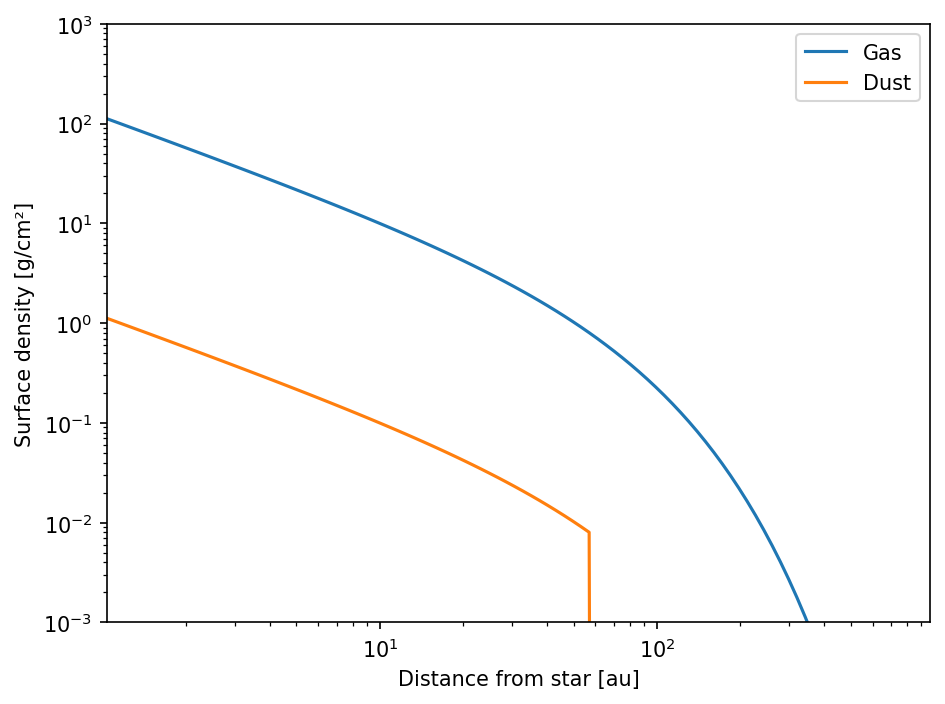

In [13]:
fig, ax = plt.subplots()
ax.loglog(sim.grid.r/c.au, sim.gas.Sigma, label="Gas")
ax.loglog(sim.grid.r/c.au, sim.dust.Sigma.sum(-1), label="Dust")
ax.set_xlim(sim.grid.r.min()/c.au, sim.grid.r.max()/c.au)
ax.set_ylim(1.e-3, 1.e3)
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel("Surface density [g/cm²]")
ax.legend()
fig.tight_layout()

The disk is initialized with the self-similar [Lynden-Bell & Pringle (1974)](https://ui.adsabs.harvard.edu/abs/1974MNRAS.168..603L/abstract) profile which is a power law with an exponential cut-off.  
The exponent of the power law in the inner disk is controlled by `sim.ini.gas.SigmaExp`, which is by default $-1$. One note of caution: if this power law exponent is changed to any other value than $-1$, other changes to the viscosity and boundary conditions need to be applied. See the [DustPy documentation](https://stammler.github.io/dustpy/test_gas_evolution.html) for details.

Outside of about $60\,\mathrm{au}$ has been removed initially. This is controlled by the `sim.ini.dust.allowDriftingParticles` switch, which is by default `False`.  
The gas surface density in the outer disk is rather low due to the exponential cut-off. This leads to rather large Stokes numbers even for small particles. These particles would be already close to their drift limit and start to drift inwards rapidly already from the beginning. This will create a visible "particle wave" in simulations. To avoid this, these particles are by default removed. Setting `sim.ini.dust.allowDriftingParticles = True` before `sim.initialize()` will initialize dust all the way to the outer boundary.

DustPy comes with a little "control panel" which can be used to investigate the model setups.

In [14]:
from dustpy import plot

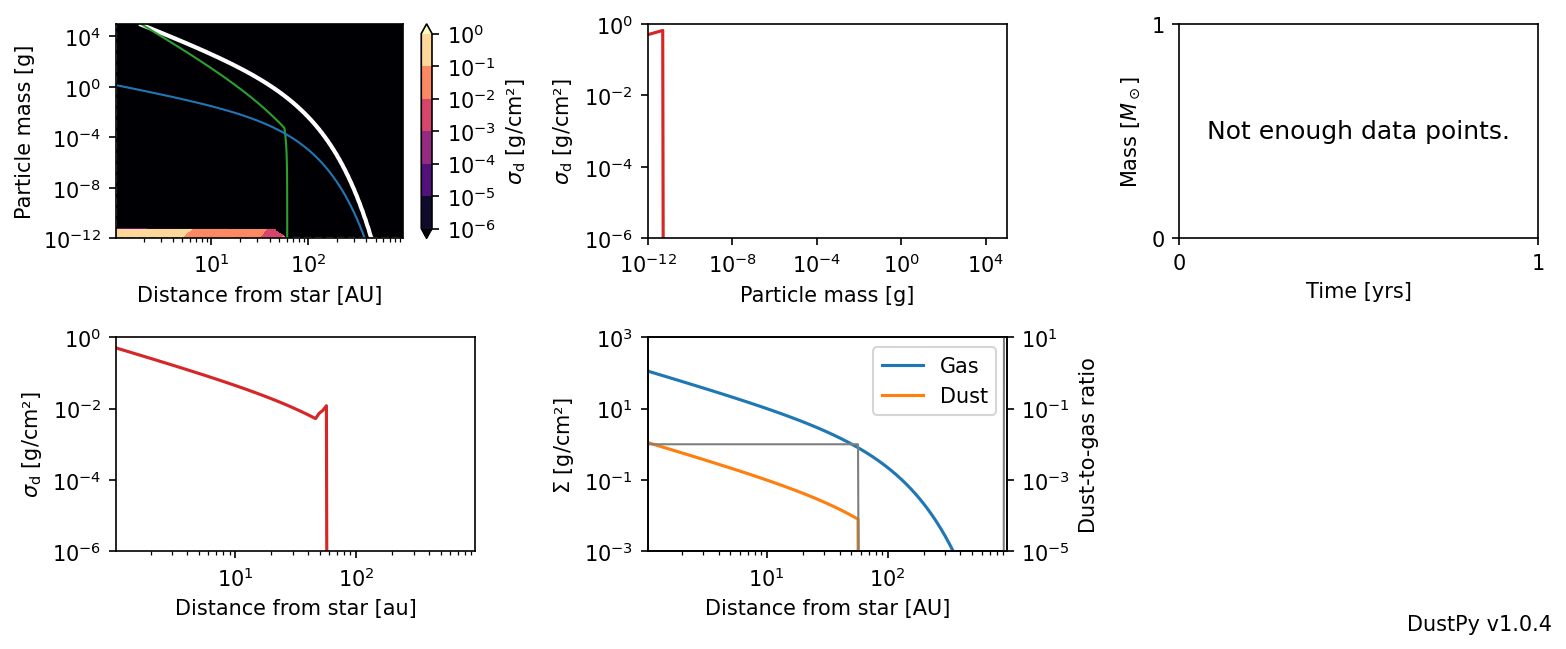

In [15]:
plot.panel(sim)

It is always good to have a look at the top left panel before starting simulations.  
The green and blue lines are analytical estimates of the drift and fragmentation limits. Before starting the simulation make sure that at any radial location one of the two is below the upper mass boundary of the simulation by some margin. Otherwise the dust particles will stop growindue to reaching the boundary and not due to some physical effects. If that is the case, increase the maximum particle size `sim.ini.grid.mmax` before calling `sim.initialize()`.

For demonstration purposes we want to limit the simulated time to $10\,000$ years.

In [16]:
import numpy as np

In [17]:
sim.t.snapshots = np.geomspace(1.e3, 1.e4, 11) * c.year

Before we start the simulation we change the name of the data directory.

In [18]:
sim.writer.datadir = "basics"

Now we can run the simulation.

In [19]:
sim.run()


DustPy v1.0.4

Documentation: https://stammler.github.io/dustpy/
PyPI:          https://pypi.org/project/dustpy/
GitHub:        https://github.com/stammler/dustpy/

Please cite Stammler & Birnstiel (2022).

Checking for mass conservation...

    - Sticking:
        max. rel. error:  2.81e-14
        for particle collision
            m[114] =  1.93e+04 g    with
            m[116] =  3.73e+04 g
    - Full fragmentation:
        max. rel. error:  4.44e-16
        for particle collision
            m[47] =  5.18e-06 g    with
            m[54] =  5.18e-05 g
    - Erosion:
        max. rel. error:  1.78e-15
        for particle collision
            m[110] =  5.18e+03 g    with
            m[118] =  7.20e+04 g

Creating data directory 'basics'.
Writing file basics/data0000.hdf5
Writing dump file basics/frame.dmp
Writing file basics/data0001.hdf5
Writing dump file basics/frame.dmp
Writing file basics/data0002.hdf5
Writing dump file basics/frame.dmp
Writing file basics/data0003.hdf5
Writin

## Inspecting the model

To inspect the model we can use the control panel again.

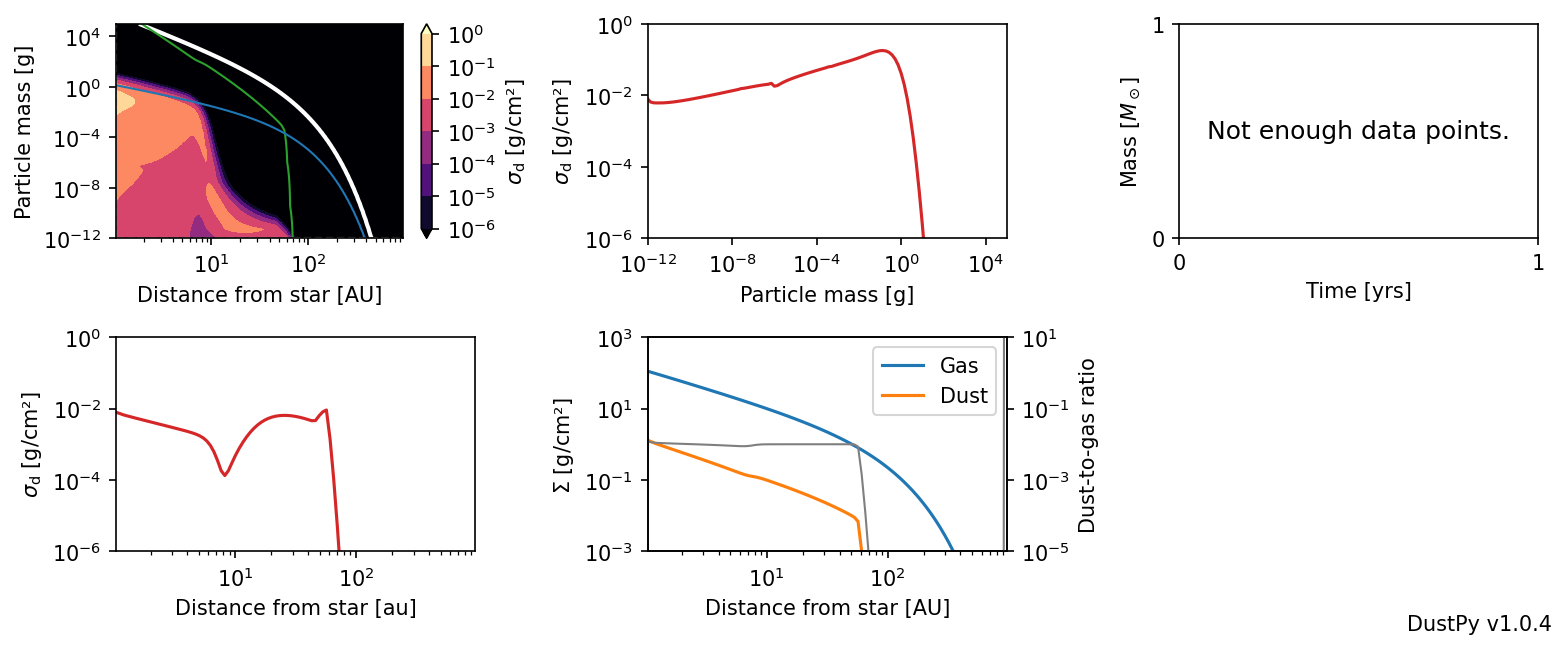

In [20]:
plot.panel(sim)

As can be seen, at the end of the simulation at $10\,000$ years dust growth has progressed outwards until about $10\,\mathrm{au}$.

We can also load the data as time sequence to investigate the model in more detail. For this we can use the writer object that is already stored in the main simulation object.

In [21]:
m = sim.writer.read.sequence("grid.m")
r = sim.writer.read.sequence("grid.r")
t = sim.writer.read.sequence("t")

SigmaD = sim.writer.read.sequence("dust.Sigma")
A = np.mean(m[0, 1:]/m[0, :-1])
B = 2*(A-1)/(A+1)
sigmaD = SigmaD/B

Here we want to plot a time sequence of the dust surface density at certain snapshots.

In [22]:
times = np.linspace(t[1], t[-1], 4)

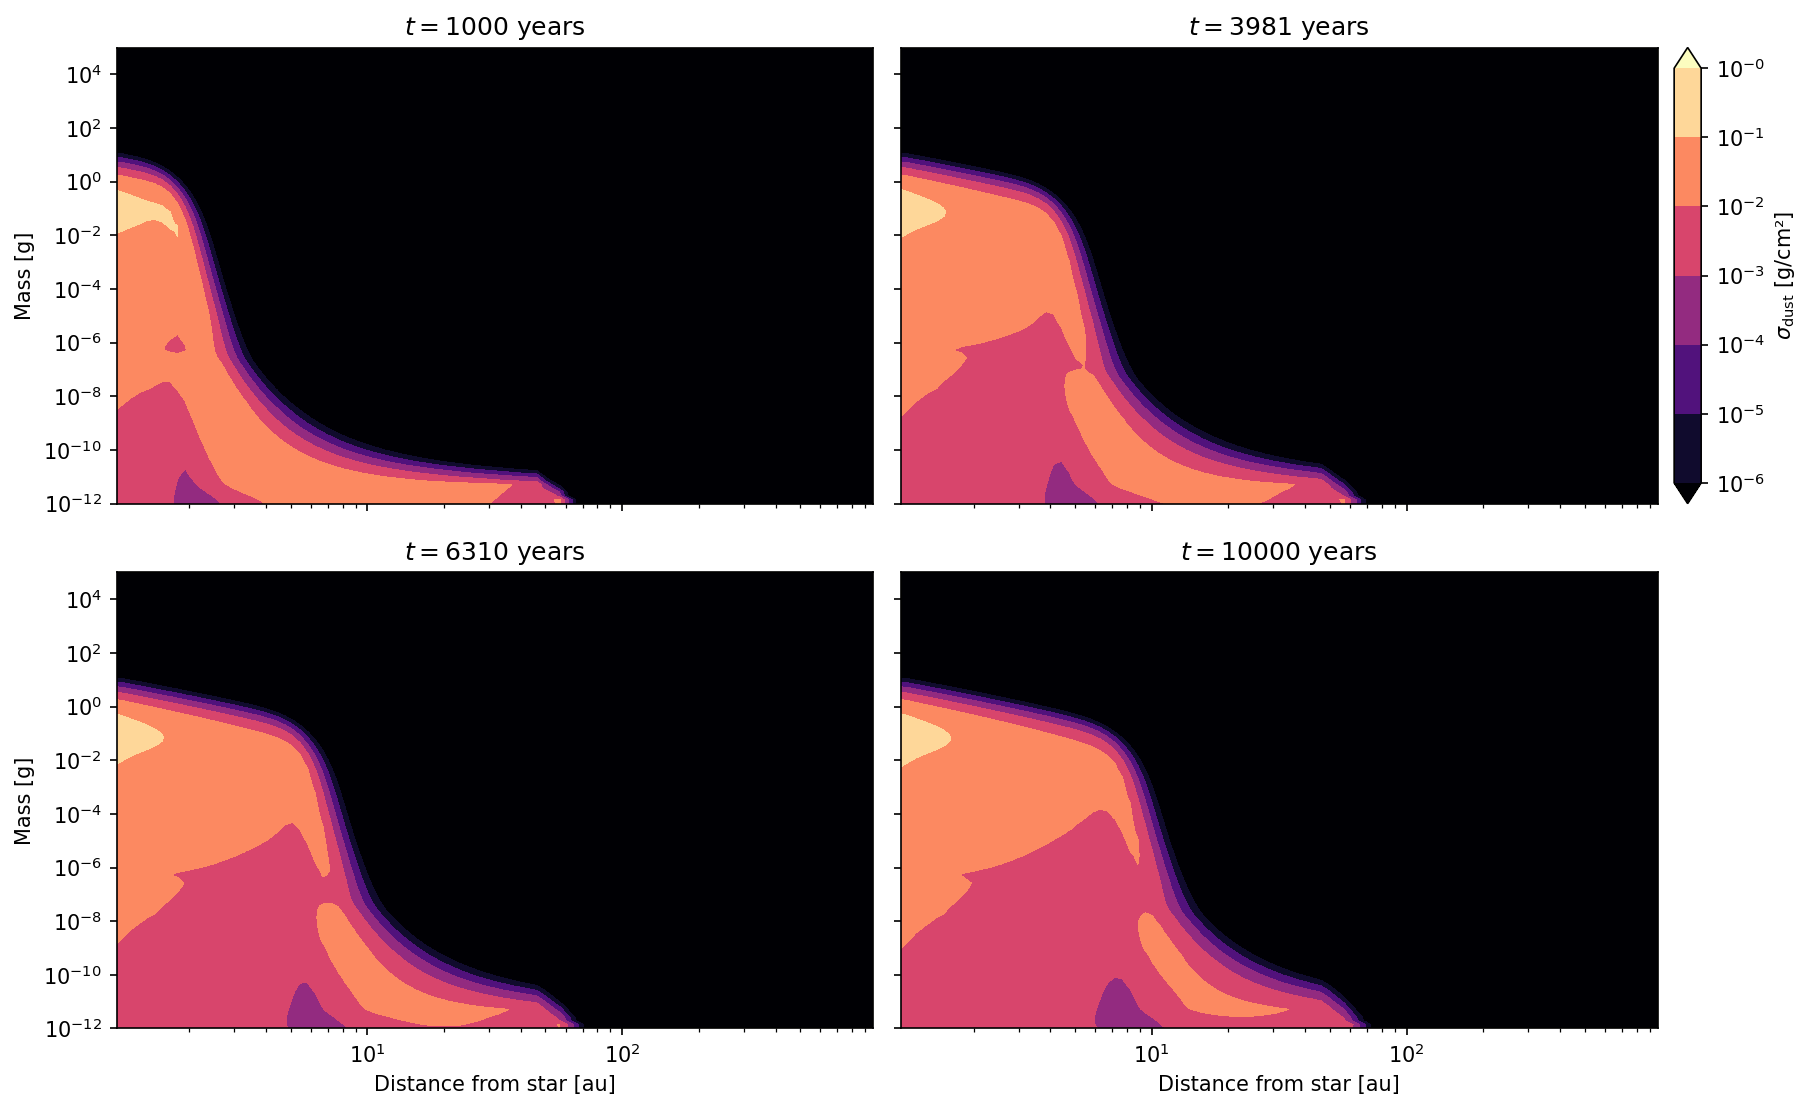

In [23]:
Nx, Ny = 2, int(np.ceil(times.shape[0]/2))
w = 6.
h = w/1.6
logsmax = np.ceil(np.log10(sigmaD.max()))
levels = np.linspace(logsmax-6, logsmax, 7)
fig, ax = plt.subplots(ncols=Nx, nrows=Ny, figsize=(Nx*w, Ny*h), sharex=True, sharey=True)
for i, time in enumerate(times):
    ix, iy = np.divmod(i, Nx)
    it = np.abs(t-time).argmin()
    plot = ax[ix, iy].contourf(r[it, :]/c.au, m[it, :], np.log10(sigmaD[it, ...].T), cmap="magma", levels=levels, extend="both")
    ax[ix, iy].set_xscale("log")
    ax[ix, iy].set_yscale("log")
    ax[ix, iy].set_title("$t = ${:.0f} years".format(t[it]/c.year))
    if ix==Nx-1:
        ax[ix, iy].set_xlabel("Distance from star [au]")
    if iy==0:
        ax[ix, iy].set_ylabel("Mass [g]")
fig.tight_layout()
fig.subplots_adjust(right=0.925)
pos01 = ax[0, -1].get_position()
cb_ax = fig.add_axes([1.01*pos01.x1, pos01.y0, 0.015, pos01.y1-pos01.y0])
cbar = fig.colorbar(plot, cax=cb_ax)
cbar.set_label("$\sigma_\mathrm{dust}$ [g/cm²]")
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(["$10^{{{:2.0f}}}$".format(e) for e in cbar.get_ticks()])

## Resuming simulations

Sometimes you want to resume a simulation from a previous state. This can be the case when you want to extend an already finished simulation or if you want to investigate why a simulation has crashed.  
DustPy is writing dump files with every output that is written, from which simulation can be resumed. In this example we are loading the dump file and extend the simulation by $1\,000$ years.

In [24]:
from dustpy import readdump

In [25]:
sim_reload = readdump("basics/frame.dmp")

Now we add a new snapshot at the end of the simulation.

In [26]:
sim_reload.t.snapshots = np.append(sim_reload.t.snapshots, 1.1*sim_reload.t)

We can now restart the simulation.

In [27]:
sim_reload.run()


DustPy v1.0.4

Documentation: https://stammler.github.io/dustpy/
PyPI:          https://pypi.org/project/dustpy/
GitHub:        https://github.com/stammler/dustpy/

Please cite Stammler & Birnstiel (2022).

Checking for mass conservation...

    - Sticking:
        max. rel. error:  2.81e-14
        for particle collision
            m[114] =  1.93e+04 g    with
            m[116] =  3.73e+04 g
    - Full fragmentation:
        max. rel. error:  4.44e-16
        for particle collision
            m[47] =  5.18e-06 g    with
            m[54] =  5.18e-05 g
    - Erosion:
        max. rel. error:  1.78e-15
        for particle collision
            m[110] =  5.18e+03 g    with
            m[118] =  7.20e+04 g

Writing file basics/data0012.hdf5
Writing dump file basics/frame.dmp
Execution time: 0:00:11


Time has now progressed further than in the previous simulation.

In [28]:
sim_reload.t/c.year

11000.0